In [2]:
import sys 
sys.path.append("..")

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass 
from physics.fom import sensitivity, sfm, mcf, tsf 
from physics.reflectometry import _kz, reflectivity

from problems.base1 import Bounds, SOISpec, CapSpec, MRL, Materials, Base1OptimizationProblem, SubstrateSpec, MRL
from data.materials_loader import load_base1_materials

/home/michaelbirtman/dev/Optimization-of-Magnetic-Reference-Layer/src/Notebooks/../problems/base1.py:68: SyntaxWarning: "\i" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\i"? A raw string is also an option.
  # x_coti \in [0,1]
/home/michaelbirtman/dev/Optimization-of-Magnetic-Reference-Layer/src/Notebooks/../problems/base1.py:124: SyntaxWarning: "\i" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\i"? A raw string is also an option.
  - x_coti \in [bounds_x.lo, bounds_x.hi]


Sample $\theta \in \mathbb{R}^4$

In [4]:
# simple magnetic SLD model for now – tweak later if you want
def m_sld_from_x(x: float) -> float:
    return 1.0 * x  # placeholder linear scaling

materials = load_base1_materials("data.json", m_sld_from_x=m_sld_from_x)




In [5]:
from math import pi 

# Random test, will match with the paper when i get the data 
sois = [
    SOISpec("SOI1", rho_n=2.0, thickness=50.0, sigma=3.0),
   # SOISpec("SOI2", rho_n=2.0, thickness=80.0, sigma=3.0),
]

Q = np.linspace(0.005, 0.3, 400)

bounds_x = Bounds(0.0, 1.0)      # x_coti
bounds_d = Bounds(20.0, 300.0)   # d_mrl
bounds_cap = Bounds(5.0, 200.0)    # d_cap

# define problem: 

problem = Base1OptimizationProblem(
    materials=materials,
    soi_list=sois,
    q_grid=Q,
    bounds_x=bounds_x,
    bounds_d=bounds_d,
    bounds_cap=bounds_cap,
)
problem

In [6]:
space = problem.search_space
print(f"Params name: {space.names}")
print(f"dimensions: {len(space)}")

theta_raw = space.sample(5)   # (5, 3)
theta = np.vstack([space.clip(row) for row in theta_raw])  # clip each row

print("Raw samples:\n", theta_raw)
print("Clipped samples:\n", theta)

x0 = space.unpack(theta[0])   # first sample as dict
x0



Params name: ['x_coti', 'd_mrl', 'd_cap', 'cap']
dimensions: 4
Raw samples:
 [[3.89729078e-01 1.84601492e+02 1.17774858e+02 0.00000000e+00]
 [2.46575463e-01 2.55049780e+02 4.77637252e+01 2.00000000e+00]
 [1.68559124e-01 2.78972771e+02 1.34393591e+02 0.00000000e+00]
 [5.52486396e-01 1.87147337e+02 7.13773354e+01 1.00000000e+00]
 [9.45088073e-01 9.81309798e+01 1.36790354e+02 1.00000000e+00]]
Clipped samples:
 [[3.89729078e-01 1.84601492e+02 1.17774858e+02 0.00000000e+00]
 [2.46575463e-01 2.55049780e+02 4.77637252e+01 2.00000000e+00]
 [1.68559124e-01 2.78972771e+02 1.34393591e+02 0.00000000e+00]
 [5.52486396e-01 1.87147337e+02 7.13773354e+01 1.00000000e+00]
 [9.45088073e-01 9.81309798e+01 1.36790354e+02 1.00000000e+00]]


{'x_coti': 0.3897290776048611,
 'd_mrl': 184.60149225656454,
 'd_cap': 117.77485764736032,
 'cap': 'Al2O3'}

In [7]:
# Eval obj 

y0 = problem.evaluate_objective(
    x_coti=x0["x_coti"],
    d_mrl=x0["d_mrl"],
    cap=x0["cap"],   
    d_cap=x0["d_cap"],
)
y0

0.33777289063469995

mateirals -> layers -> reflectivity -> fom -> TSF 

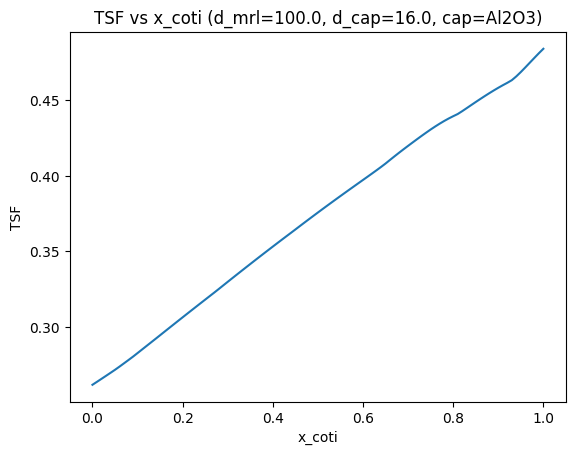

In [8]:
xs = np.linspace(bounds_x.lo, bounds_x.hi, 101)
ys = []

fixed_d_mrl = 100.0
fixed_d_cap = 16.0
fixed_cap = list(materials.caps.keys())[0]  # e.g. "Al2O3"

for x_coti in xs:
    ys.append(
        problem.evaluate_objective(
            x_coti=x_coti,
            d_mrl=fixed_d_mrl,
            cap=fixed_cap,
            d_cap=fixed_d_cap,
        )
    )

plt.plot(xs, ys)
plt.xlabel("x_coti")
plt.ylabel("TSF")
plt.title(f"TSF vs x_coti (d_mrl={fixed_d_mrl}, d_cap={fixed_d_cap}, cap={fixed_cap})")
plt.show()


## Small random search 


In [10]:
best_y = -np.inf 
best_x = None 


evals: int = 2000

for i in range(evals): 
    theta = space.clip(space.sample(1)[0])
    x = space.unpack(theta)

    y = problem.evaluate_objective(
        x_coti=x["x_coti"],
        d_mrl=x["d_mrl"], 
        cap=x["cap"],
        d_cap=x["d_cap"],
    )

    if y > best_y: 
        best_y = y
        best_x = x


print(f"best y: {best_y}")
print("--------------")
print(f"best x: {best_x}")

best y: 1.1154866419980123
--------------
best x: {'x_coti': 0.877247551559974, 'd_mrl': 198.64322360047174, 'd_cap': 194.73336703027937, 'cap': 'SiO2'}


# PLOT REFLECTICIY AND SENSTTIVITY FOR TESTIG 

In [ ]:
Q = np.linspace(0.005, 0.3, 400)

AttributeError: module 'numpy' has no attribute 'lin'